# Sensors

A special object in rendervous is a sensor. Sensors are maps with a special method ```capture```. They represent a set of measurements arranged in space with a customized map. This is useful for cameras, grids, images, light probes.

Mathematically can be seen as the array:

$$
(I_k) = \int_{X^{(k)}} f(x) d\mu(x) 
$$

For example, in the case of a camera, $x$ could represent rays (position and direction), and $X$ is the set of possible arriving rays to a specific camera sensor in the film. Then $f$ represents a radiance field, captured by the each sensor $k$ to conform the image $I$.  

In practice, the integral is solved with Montecarlo and the sensor map represents a perfect-importance sampler for $x\sim \mu(x)$.

$$
(I_k) = \mathbb{E}_{x \sim \mu(x)}\left[ f(x) \right]
$$

In [1]:
import rendervous as rdv
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

## Sensing a field



In [ ]:
def torch_toy_field(p):
    x = p[...,0:1]
    y = p[...,1:2]
    z = p[...,2:3]
    return torch.sin(x*x) + torch.cos(y*5) * 2 + torch.sin(z*3) * 0.1

def torch_capture(f, width, height, depth):
    x = torch.arange(-1.0 + 1.0/width, 1.0, 2.0/width).to(rdv.device())
    y = torch.arange(-1.0 + 1.0/height, 1.0, 2.0/height).to(rdv.device())
    z = torch.arange(-1.0 + 1.0/depth, 1.0, 2.0/depth).to(rdv.device())
    p = torch.cartesian_prod(z, y, x)[...,[2,1,0]]
    return torch_toy_field(p).view(depth, height, width, 1)

x_map = rdv.X.cast(output_dim=3)[0]
y_map = rdv.X.cast(output_dim=3)[1]
z_map = rdv.X.cast(output_dim=3)[2]
toy_field = rdv.sin.after(x_map * x_map) + rdv.cos.after(y_map * 5) * 2 + rdv.sin.after(z_map * 3) * 0.1

In [ ]:
grid_sensor = rdv.Grid3DSensor(256, 256, 256)
g1 = grid_sensor.capture(toy_field)

In [ ]:
for _ in tqdm(range(1000)):
    g1 = grid_sensor.capture(toy_field)
# plt.imshow(g1.cpu()[g1.shape[0]//2,:,:,0])
# plt.show()

In [ ]:
for _ in tqdm(range(1000)):
    g2 = torch_capture(torch_toy_field, 256, 256, 256)
    torch.cuda.synchronize()
    # torch.cuda.empty_cache()
# for _ in range(1000):
#     g2 = torch_capture(torch_toy_field, 256, 256, 256)
#     if g2[1,1,1,0] == 0.0:
#         print(g2.shape)
#     # torch.cuda.empty_cache()

## Cameras

Let's define a basic radiance field representing just light comming from an environment, i.e. $L_i(x,w) = B(w)$.

In [2]:
import rendervous.datasets
env = rdv.datasets.Images.environment_example.to(rdv.device())

# create an image with the tensor
env_image = rdv.Image2D(env)

# convert a ray into an equirectangular 2D coordinate, then sample an image
env_map = rdv.xr_ray_projection.then(rdv.sample[env])

camera = rdv.PerspectiveCameraSensor(
    width=512, 
    height=512,
    poses=rdv.look_at_poses((0.0, 0.0, -2.0))
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09768034..1.399276].


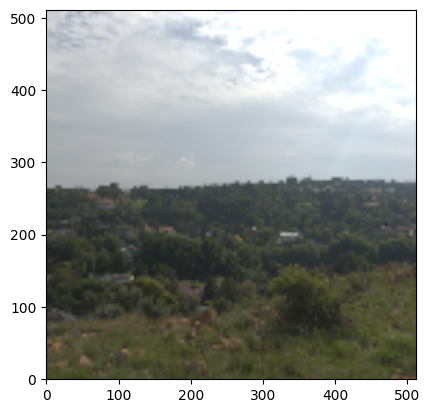

In [4]:
R = camera.capture(env_map)

plt.imshow(R[0].cpu() ** (1.0/2.2))
plt.gca().invert_yaxis()
plt.show()